In [1]:
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder.appName("CreditCardSystem").getOrCreate()

In [3]:
branch_df = spark.read.json("cdw_sapp_branch.json")
creditcard_df = spark.read.json("cdw_sapp_credit.json")
customer_df = spark.read.json("cdw_sapp_custmer.json")

In [4]:
branch_df.show()
creditcard_df.show()
customer_df.show()

+-----------------+-----------+------------+------------+------------+-------------------+----------+--------------------+
|      BRANCH_CITY|BRANCH_CODE| BRANCH_NAME|BRANCH_PHONE|BRANCH_STATE|      BRANCH_STREET|BRANCH_ZIP|        LAST_UPDATED|
+-----------------+-----------+------------+------------+------------+-------------------+----------+--------------------+
|        Lakeville|          1|Example Bank|  1234565276|          MN|       Bridle Court|     55044|2018-04-18T16:51:...|
|          Huntley|          2|Example Bank|  1234618993|          IL|  Washington Street|     60142|2018-04-18T16:51:...|
|SouthRichmondHill|          3|Example Bank|  1234985926|          NY|      Warren Street|     11419|2018-04-18T16:51:...|
|       Middleburg|          4|Example Bank|  1234663064|          FL|   Cleveland Street|     32068|2018-04-18T16:51:...|
|    KingOfPrussia|          5|Example Bank|  1234849701|          PA|        14th Street|     19406|2018-04-18T16:51:...|
|         Paters

In [5]:
from pyspark.sql.functions import initcap, lower, concat_ws, regexp_replace


In [6]:
customer_df = customer_df.withColumn("FIRST_NAME", initcap(customer_df["FIRST_NAME"]))
customer_df = customer_df.withColumn("MIDDLE_NAME", lower(customer_df["MIDDLE_NAME"]))
customer_df = customer_df.withColumn("LAST_NAME", initcap(customer_df["LAST_NAME"]))
customer_df = customer_df.withColumn("FULL_STREET_ADDRESS", concat_ws(", ", customer_df["STREET_NAME"], customer_df["APT_NO"]))


In [7]:
customer_df.show()

+------+----------------+------------+-------------+--------------------+----------+----------+--------+----------+---------+--------------------+-----------+---------+-----------------+--------------------+
|APT_NO|  CREDIT_CARD_NO|   CUST_CITY| CUST_COUNTRY|          CUST_EMAIL|CUST_PHONE|CUST_STATE|CUST_ZIP|FIRST_NAME|LAST_NAME|        LAST_UPDATED|MIDDLE_NAME|      SSN|      STREET_NAME| FULL_STREET_ADDRESS|
+------+----------------+------------+-------------+--------------------+----------+----------+--------+----------+---------+--------------------+-----------+---------+-----------------+--------------------+
|   656|4210653310061055|     Natchez|United States| AHooper@example.com|   1237818|        MS|   39120|      Alec|   Hooper|2018-04-21T12:49:...|         wm|123456100|Main Street North|Main Street North...|
|   829|4210653310102868|Wethersfield|United States| EHolman@example.com|   1238933|        CT|   06109|      Etta|   Holman|2018-04-21T12:49:...|    brendan|123453023|

In [8]:
from pyspark.sql import functions as F

customer_df = customer_df.withColumn(
    "CUST_PHONE",
    F.when(
        F.length(customer_df["CUST_PHONE"]) == 7,
        F.concat(F.lit("555"), customer_df["CUST_PHONE"])
    ).otherwise(customer_df["CUST_PHONE"])
)

In [9]:
customer_df.show()

+------+----------------+------------+-------------+--------------------+----------+----------+--------+----------+---------+--------------------+-----------+---------+-----------------+--------------------+
|APT_NO|  CREDIT_CARD_NO|   CUST_CITY| CUST_COUNTRY|          CUST_EMAIL|CUST_PHONE|CUST_STATE|CUST_ZIP|FIRST_NAME|LAST_NAME|        LAST_UPDATED|MIDDLE_NAME|      SSN|      STREET_NAME| FULL_STREET_ADDRESS|
+------+----------------+------------+-------------+--------------------+----------+----------+--------+----------+---------+--------------------+-----------+---------+-----------------+--------------------+
|   656|4210653310061055|     Natchez|United States| AHooper@example.com|5551237818|        MS|   39120|      Alec|   Hooper|2018-04-21T12:49:...|         wm|123456100|Main Street North|Main Street North...|
|   829|4210653310102868|Wethersfield|United States| EHolman@example.com|5551238933|        CT|   06109|      Etta|   Holman|2018-04-21T12:49:...|    brendan|123453023|

In [10]:
customer_df = customer_df.withColumn("CUST_PHONE",
                                      F.concat(F.lit("("),
                                               F.substring("CUST_PHONE", 1, 3),
                                               F.lit(")"),
                                               F.substring("CUST_PHONE", 4, 3),
                                               F.lit("-"),
                                               F.substring("CUST_PHONE", 7, 4)))


In [11]:
customer_df.show()

+------+----------------+------------+-------------+--------------------+-------------+----------+--------+----------+---------+--------------------+-----------+---------+-----------------+--------------------+
|APT_NO|  CREDIT_CARD_NO|   CUST_CITY| CUST_COUNTRY|          CUST_EMAIL|   CUST_PHONE|CUST_STATE|CUST_ZIP|FIRST_NAME|LAST_NAME|        LAST_UPDATED|MIDDLE_NAME|      SSN|      STREET_NAME| FULL_STREET_ADDRESS|
+------+----------------+------------+-------------+--------------------+-------------+----------+--------+----------+---------+--------------------+-----------+---------+-----------------+--------------------+
|   656|4210653310061055|     Natchez|United States| AHooper@example.com|(555)123-7818|        MS|   39120|      Alec|   Hooper|2018-04-21T12:49:...|         wm|123456100|Main Street North|Main Street North...|
|   829|4210653310102868|Wethersfield|United States| EHolman@example.com|(555)123-8933|        CT|   06109|      Etta|   Holman|2018-04-21T12:49:...|    bre

In [12]:
branch_df.createOrReplaceTempView("branch")
creditcard_df.createOrReplaceTempView("creditcard")
customer_df.createOrReplaceTempView("customer")

In [13]:
result = spark.sql("""
    SELECT * 
    FROM customer c
    JOIN creditcard cc ON c.SSN = cc.CUST_SSN
    JOIN branch b ON cc.BRANCH_CODE = b.BRANCH_CODE
""")


In [14]:
result.show()

+------+----------------+------------+-------------+-------------------+-------------+----------+--------+----------+---------+--------------------+-----------+---------+------------+-------------------+-----------+----------------+---------+---+-----+--------------+----------------+-----------------+----+-----------------+-----------+------------+------------+------------+---------------+----------+--------------------+
|APT_NO|  CREDIT_CARD_NO|   CUST_CITY| CUST_COUNTRY|         CUST_EMAIL|   CUST_PHONE|CUST_STATE|CUST_ZIP|FIRST_NAME|LAST_NAME|        LAST_UPDATED|MIDDLE_NAME|      SSN| STREET_NAME|FULL_STREET_ADDRESS|BRANCH_CODE|  CREDIT_CARD_NO| CUST_SSN|DAY|MONTH|TRANSACTION_ID|TRANSACTION_TYPE|TRANSACTION_VALUE|YEAR|      BRANCH_CITY|BRANCH_CODE| BRANCH_NAME|BRANCH_PHONE|BRANCH_STATE|  BRANCH_STREET|BRANCH_ZIP|        LAST_UPDATED|
+------+----------------+------------+-------------+-------------------+-------------+----------+--------+----------+---------+--------------------+--

In [15]:
result_left = spark.sql("""
    SELECT *
    FROM customer c
    LEFT JOIN creditcard cc ON c.SSN = cc.CUST_SSN
    LEFT JOIN branch b ON cc.BRANCH_CODE = b.BRANCH_CODE
    WHERE cc.CUST_SSN IS NULL OR b.BRANCH_CODE IS NULL
""")

In [16]:
result_right = customer_df.join(creditcard_df, customer_df.SSN == creditcard_df.CUST_SSN, "right") \
                    .join(branch_df, creditcard_df.BRANCH_CODE == branch_df.BRANCH_CODE, "right")

result_right.show()

+------+----------------+---------------+-------------+--------------------+-------------+----------+--------+----------+---------+--------------------+-----------+---------+-----------------+--------------------+-----------+----------------+---------+---+-----+--------------+----------------+-----------------+----+-----------+-----------+------------+------------+------------+----------------+----------+--------------------+
|APT_NO|  CREDIT_CARD_NO|      CUST_CITY| CUST_COUNTRY|          CUST_EMAIL|   CUST_PHONE|CUST_STATE|CUST_ZIP|FIRST_NAME|LAST_NAME|        LAST_UPDATED|MIDDLE_NAME|      SSN|      STREET_NAME| FULL_STREET_ADDRESS|BRANCH_CODE|  CREDIT_CARD_NO| CUST_SSN|DAY|MONTH|TRANSACTION_ID|TRANSACTION_TYPE|TRANSACTION_VALUE|YEAR|BRANCH_CITY|BRANCH_CODE| BRANCH_NAME|BRANCH_PHONE|BRANCH_STATE|   BRANCH_STREET|BRANCH_ZIP|        LAST_UPDATED|
+------+----------------+---------------+-------------+--------------------+-------------+----------+--------+----------+---------+---------

In [17]:
result_outer = customer_df.join(creditcard_df, customer_df.SSN == creditcard_df.CUST_SSN, "outer") \
                    .join(branch_df, creditcard_df.BRANCH_CODE == branch_df.BRANCH_CODE, "outer")

result_outer.show()

+------+----------------+-------------+-------------+--------------------+-------------+----------+--------+----------+---------+--------------------+-----------+---------+----------------+--------------------+-----------+----------------+---------+---+-----+--------------+----------------+-----------------+----+-----------+-----------+------------+------------+------------+----------------+----------+--------------------+
|APT_NO|  CREDIT_CARD_NO|    CUST_CITY| CUST_COUNTRY|          CUST_EMAIL|   CUST_PHONE|CUST_STATE|CUST_ZIP|FIRST_NAME|LAST_NAME|        LAST_UPDATED|MIDDLE_NAME|      SSN|     STREET_NAME| FULL_STREET_ADDRESS|BRANCH_CODE|  CREDIT_CARD_NO| CUST_SSN|DAY|MONTH|TRANSACTION_ID|TRANSACTION_TYPE|TRANSACTION_VALUE|YEAR|BRANCH_CITY|BRANCH_CODE| BRANCH_NAME|BRANCH_PHONE|BRANCH_STATE|   BRANCH_STREET|BRANCH_ZIP|        LAST_UPDATED|
+------+----------------+-------------+-------------+--------------------+-------------+----------+--------+----------+---------+-----------------

In [18]:
import mysql.connector

conn = mysql.connector.connect(user='root', 
                               database='creditcard_capstone',
                               password='password',
                               host="localhost",
                               port=3306)
cursor = conn.cursor()

In [20]:
cursor.execute("drop table if exists creditcard;")
cursor.execute("drop table if exists customer;")
cursor.execute("drop table if exists branch;")
cursor.execute("drop table if exists cdw_sapp_loan_application;")

In [21]:
# Write to MySQL Table
branch_df.write \
  .format("jdbc") \
  .option("driver","com.mysql.cj.jdbc.Driver") \
  .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
  .option("dbtable", "branch") \
  .option("user", "root") \
  .option("password", "password") \
  .save()



In [22]:
customer_df.write \
  .format("jdbc") \
  .option("driver","com.mysql.cj.jdbc.Driver") \
  .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
  .option("dbtable", "customer") \
  .option("user", "root") \
  .option("password", "password") \
  .save()

In [23]:
creditcard_df.write \
  .format("jdbc") \
  .option("driver","com.mysql.cj.jdbc.Driver") \
  .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
  .option("dbtable", "creditcard") \
  .option("user", "root") \
  .option("password", "password") \
  .save()

In [97]:
conn.close()

********************************
*2.1 Transaction Details Module*
********************************

In [36]:
import mysql.connector

def zip_transactions(zip_code, month, year):

    conn = mysql.connector.connect(user='root', 
                                   database='creditcard_capstone',
                                   password='password',
                                   host="localhost",
                                   port=3306)

    # Create a cursor to execute SQL queries
    cursor = conn.cursor()

    # SQL query to retrieve the transactions made by customers in a given zip code for a given month and year
    query = """
    SELECT *
    FROM customer c
    LEFT JOIN creditcard cc ON c.SSN = cc.CUST_SSN
    LEFT JOIN branch b ON cc.BRANCH_CODE = b.BRANCH_CODE
    WHERE c.CUST_ZIP = %s AND cc.MONTH = %s AND cc.YEAR = %s
    ORDER BY cc.DAY DESC
    """

    # Execute the query with the provided parameters
    cursor.execute(query, (zip_code, month, year))

    # Fetch all the results
    results = cursor.fetchall()

    # Display the transactions
    print("Transactions by Zip Code and Dates:")
    for row in results:
        print(row)
    print("Transactions printed Successfully.")

    # Close the cursor and the database connection
    cursor.close()
    conn.close()

In [33]:
def type_transactions(transaction_type):
    # Establish a connection to the MySQL database

    conn = mysql.connector.connect(user='root', 
                                   database='creditcard_capstone',
                                   password='password',
                                   host="localhost",
                                   port=3306)

    # Create a cursor to execute SQL queries
    cursor = conn.cursor()

    # SQL query to retrieve the number and total values of transactions for a given type
    query = """
    SELECT COUNT(*) AS transaction_count, SUM(Transaction_Value) AS total_value
    FROM creditcard
    WHERE TRANSACTION_TYPE = %s
    """

    # Execute the query with the provided parameter
    cursor.execute(query, (transaction_type,))

    # Fetch the result
    result = cursor.fetchone()

    # Display the transaction details
    print("Transaction Type:", transaction_type)
    print("Transaction Count:", result[0])
    print("Total Value:", result[1])

    # Close the cursor and the database connection
    cursor.close()
    conn.close()

In [34]:
def state_transactions(state):
    # Establish a connection to the MySQL database
    conn = mysql.connector.connect(user='root',
                                   database='creditcard_capstone',
                                   password='password',
                                   host="localhost",
                                   port=3306)

    # Create a cursor to execute SQL queries
    cursor = conn.cursor()

    # SQL query to retrieve the total number and total values of transactions for branches in a given state
    query = """
    SELECT COUNT(*) AS transaction_count, SUM(Transaction_Value) AS total_value
    FROM creditcard
    JOIN branch ON creditcard.BRANCH_CODE = branch.BRANCH_CODE
    WHERE branch.BRANCH_STATE = %s
    """

    # Execute the query with the provided parameter
    cursor.execute(query, (state,))

    # Fetch the result
    result = cursor.fetchone()

    # Display the transaction details
    print("State:", state)
    print("Transaction Count:", result[0])
    print("Total Value:", result[1])

    # Close the cursor and the database connection
    cursor.close()
    conn.close()

In [35]:
# Main program
def main_one():
    while True:
        print("Transaction Details Module")
        print("1) Display transactions by zip code for a given month and year")
        print("2) Display number and total values of transactions for a given type")
        print("3) Display total number and total values of transactions for branches in a given state")
        print("4) Exit")

        choice = input("Enter your choice (1-3 or 4 to Exit): ")

        if choice == "1":
            zip_code = input("Enter the zip code(Ex:12345): ")
            month = input("Enter the month(For January, enter 1): ")
            year = input("Enter the year(Ex:2018): ")
            zip_transactions(zip_code, month, year)
        elif choice == "2":
            transaction_type = input("Enter the transaction type(Ex:Gas): ")
            type_transactions(transaction_type)
        elif choice == "3":
            state = input("Enter the state(Ex:NY): ")
            state_transactions(state)
        elif choice == "4":
            break
        else:
            print("Invalid choice. Please try again.")

if __name__ == "__main__":
    main_one() 

Transaction Details Module
1) Display transactions by zip code for a given month and year
2) Display number and total values of transactions for a given type
3) Display total number and total values of transactions for branches in a given state
4) Exit


Transactions by Zip Code and Dates:
('731', '4210653390959197', 'Natchez', 'United States', 'ODickinson@example.com', '(555)123-6684', 'MS', '39120', 'Omer', 'Dickinson', '2018-04-21T12:49:02.000-04:00', 'lauri', 123457054, 'Cross Street', 'Cross Street, 731', 118, '4210653390959197', 123457054, 28, 4, 15808, 'Grocery', 81.26, 2018, 'Hanover', 118, 'Example Bank', '1234498005', 'PA', 'Henry Street', 17331, '2018-04-18T16:51:47.000-04:00')
('656', '4210653310061055', 'Natchez', 'United States', 'AHooper@example.com', '(555)123-7818', 'MS', '39120', 'Alec', 'Hooper', '2018-04-21T12:49:02.000-04:00', 'wm', 123456100, 'Main Street North', 'Main Street North, 656', 28, '4210653310061055', 123456100, 28, 4, 20552, 'Healthcare', 27.08, 2018, 'Midlothian', 28, 'Example Bank', '1234416595', 'VA', '3rd Street West', 23112, '2018-04-18T16:51:47.000-04:00')
('718', '4210653362697310', 'Natchez', 'United States', 'MHagan@example.com', '(555)124-3335', 'MS', '39120', 'Melissa', 'Hagan', '2018-04-21T

*****************************
*2.2 Customer Details Module*
*****************************

In [37]:
import mysql.connector

def display_account(customer_ssn):
    # Establish a connection to the MySQL database
    conn = mysql.connector.connect(user='root',
                                   database='creditcard_capstone',
                                   password='password',
                                   host="localhost",
                                   port=3306)

    # Create a cursor to execute SQL queries
    cursor = conn.cursor()

    # SQL query to retrieve the account details of a customer
    query = """
    SELECT *
    FROM customer
    WHERE SSN = %s
    """

    # Execute the query with the provided parameter
    cursor.execute(query, (customer_ssn,))

    # Fetch the result
    result = cursor.fetchone()

    # Display the account details
    print("Account Details:")
    print("SSN:", result[12])
    print("First Name:", result[8])
    print("Middle Name:", result[11])
    print("Last Name:", result[9])
    print("Street Name:", result[13])
    print("City:", result[2])
    print("State:", result[6])
    print("Zip Code:", result[7])
    print("Country:", result[3])
    print("Phone:", result[5])
    print("Email:", result[4])

    # Close the cursor and the database connection
    cursor.close()
    conn.close()

In [38]:
def modify_account(customer_ssn):
    # Establish a connection to the MySQL database
    conn = mysql.connector.connect(user='root',
                                   database='creditcard_capstone',
                                   password='password',
                                   host="localhost",
                                   port=3306)

    # Create a cursor to execute SQL queries
    cursor = conn.cursor()
    
    column_name_dict = {0:'APT_NO',       1:'CREDIT_CARD_NO', 
                        2:'CUST_CITY',    3:'CUST_COUNTRY',
                        4:'CUST_EMAIL',   5:'CUST_PHONE',
                        6:'CUST_STATE',   7:'CUST_ZIP',
                        8:'FIRST_NAME',   9:'LAST_NAME',
                        10:'LAST_UPDATED',11:'MIDDLE_NAME',
                        12:'SSN',         13:'STREET_NAME',
                        14:'FULL_STREET_ADDRESS'}
    
    # Get user input for column name and new value
    print("Field No.Key:")
    print("0 = Apartment    1 = Credit Card No.   2 = City                 3 = Country")
    print("4 = Email        5 = Phone             6 = State                7 = Zip Code")
    print("8 = First Name   9 = Last Name        10 = Last Updated Date   11 = Middle Name")
    print("12 = SS No.     13 = Street Name      14 = Full Address")

    field = int(input("Enter the field to modify: "))
    new_value = int(input("Enter the new value: "))

    # SQL query to update the account details of a customer
    query = f"UPDATE customer SET {column_name_dict.get(field)} = '{new_value}', last_updated = DATE_FORMAT(now(), '%Y-%m-%d %k:%i') WHERE SSN = {customer_ssn};"
    
    cursor.execute(query)

    # Commit the changes
    conn.commit()

    # Display a success message
    print("Account details updated successfully.")

    # Close the cursor and the database connection
    cursor.close()
    conn.close()

In [39]:
def monthly_bill(credit_card_no, month, year):
    # Establish a connection to the MySQL database
    conn = mysql.connector.connect(user='root',
                                   database='creditcard_capstone',
                                   password='password',
                                   host="localhost",
                                   port=3306)

    # Create a cursor to execute SQL queries
    cursor = conn.cursor()

    # SQL query to calculate the monthly bill for a credit card number
    query = """
    SELECT SUM(Transaction_Value) AS total_bill
    FROM creditcard
    WHERE CREDIT_CARD_NO = %s AND MONTH = %s AND YEAR = %s
    """

    # Execute the query with the provided parameters
    cursor.execute(query, (credit_card_no, month, year))

    # Fetch the result
    result = cursor.fetchone()

    # Display the monthly bill
    print("Monthly Bill:")
    print("Credit Card Number:", credit_card_no)
    print("Month:", month)
    print("Year:", year)
    print("Total Bill:", result[0])

    # Close the cursor and the database connection
    cursor.close()
    conn.close()


In [40]:
def dates_transactions(customer_ssn, start_date, end_date):
    # Establish a connection to the MySQL database
    conn = mysql.connector.connect(user='root',
                                   database='creditcard_capstone',
                                   password='password',
                                   host="localhost",
                                   port=3306)

    # Create a cursor to execute SQL queries
    cursor = conn.cursor()

    # SQL query to retrieve the transactions made by a customer between two dates
    query = f"SELECT ROUND(SUM(TRANSACTION_VALUE),2) FROM creditcard where CUST_SSN = {customer_ssn} AND DATE_ADD(DATE_ADD(MAKEDATE(`YEAR`, 1), INTERVAL (`MONTH`)-1 MONTH), INTERVAL (`DAY`)-1 DAY) between '{start_date}' and '{end_date}';"


    # Execute the query with the provided parameters
    # cursor.execute(query, (customer_ssn, start_date, end_date))
    cursor.execute(query)

    # Fetch all the results
    results = cursor.fetchall()

    # Display the transaction details
    print("Transactions by Customer and Dates:")
    for row in results:
        print(row[0])

    # Close the cursor and the database connection
    cursor.close()
    conn.close()


In [42]:
# Main program
def main_two():
    while True:
        print("Customer Details Module")
        print("1) Display account details of a customer")
        print("2) Modify account details of a customer")
        print("3) Generate monthly bill for a credit card number")
        print("4) Display transactions made by a customer between two dates")

        choice = input("Enter your choice (1-4 or 5 to Exit): ")

        if choice == "1":
            customer_ssn = input("Enter customer SSN: ")
            display_account(customer_ssn)
        elif choice == "2":
            customer_ssn = input("Enter customer SSN: ")
            # field = input("Enter the field to modify: ")
            # new_value = input("Enter the new value: ")
            modify_account(customer_ssn)
        elif choice == "3":
            credit_card_no = input("Enter credit card number: ")
            month = input("Enter month: ")
            year = input("Enter year: ")
            monthly_bill(credit_card_no, month, year)
        elif choice == "4":
            customer_ssn = input("Enter customer SSN: ")
            start_date = input("Enter start date (YYYY-MM-DD): ")
            end_date = input("Enter end date (YYYY-MM-DD): ")
            dates_transactions(customer_ssn, start_date, end_date)
        elif choice == "5":
            break
        else:
            print("Invalid choice. Please try again.")

# Run the main program
if __name__ == "__main__":
    main_two()


Customer Details Module
1) Display account details of a customer
2) Modify account details of a customer
3) Generate monthly bill for a credit card number
4) Display transactions made by a customer between two dates
Account Details:
SSN: 123456100
First Name: Alec
Middle Name: wm
Last Name: Hooper
Street Name: Main Street North
City: Natchez
State: MS
Zip Code: 39120
Country: United States
Phone: (555)123-7818
Email: AHooper@example.com
Customer Details Module
1) Display account details of a customer
2) Modify account details of a customer
3) Generate monthly bill for a credit card number
4) Display transactions made by a customer between two dates
Field No.Key:
0 = Apartment    1 = Credit Card No.   2 = City                 3 = Country
4 = Email        5 = Phone             6 = State                7 = Zip Code
8 = First Name   9 = Last Name        10 = Last Updated Date   11 = Middle Name
12 = SS No.     13 = Street Name      14 = Full Address
Account details updated successfully.
Cu

In [ ]:
cursor.close()
conn.close()
spark.stop()

****************************************************************
*III. Functional Requirements - Data Analysis and Visualization*
****************************************************************

*****************************
*Functional Requirements 3.1*
*****************************

C:\Users\ibadw\AppData\Local\Temp\ipykernel_25468\4212519927.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


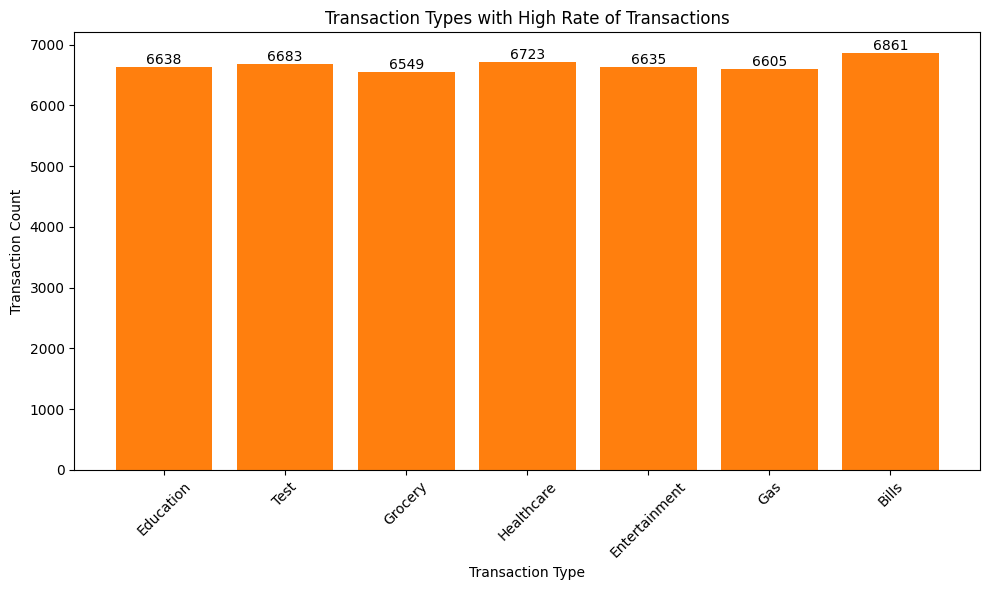

In [43]:
import matplotlib.pyplot as plt
import pandas as pd
import mysql.connector

# Establish a connection to the MySQL database
conn = mysql.connector.connect(user='root',
                               database='creditcard_capstone',
                               password='password',
                               host="localhost",
                               port=3306)

# Execute a query to get the transaction type counts
query = """
SELECT TRANSACTION_TYPE, COUNT(*) AS transaction_count
FROM creditcard
GROUP BY TRANSACTION_TYPE
"""

# Fetch the results into a Pandas DataFrame
df = pd.read_sql(query, conn)

# Plot the transaction types and their counts
plt.figure(figsize=(10, 6))
bars = plt.bar(df["TRANSACTION_TYPE"], df["transaction_count"])
plt.bar(df["TRANSACTION_TYPE"], df["transaction_count"])
plt.xlabel("Transaction Type")
plt.ylabel("Transaction Count")
plt.title("Transaction Types with High Rate of Transactions")
plt.xticks(rotation=45)
plt.tight_layout()

# Add the total count on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, height, ha='center', va='bottom')

# Save the plot as an image
plt.savefig("transaction_types.png")

# Close the database connection
conn.close()


*****************************
*Functional Requirements 3.2*
*****************************

C:\Users\ibadw\AppData\Local\Temp\ipykernel_25468\3932192534.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


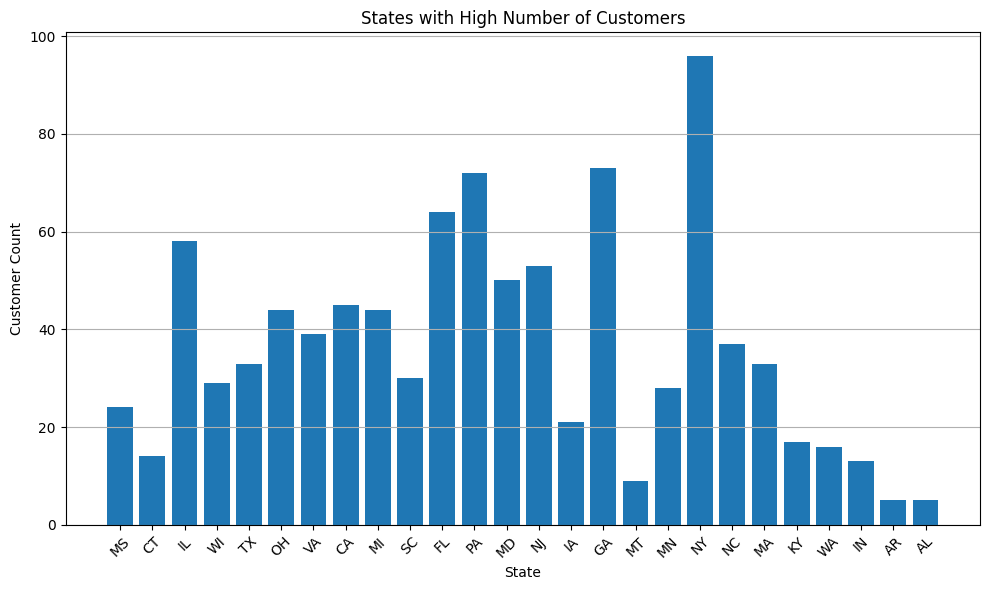

In [45]:
import matplotlib.pyplot as plt
import pandas as pd
import mysql.connector

# Establish a connection to the MySQL database
conn = mysql.connector.connect(user='root',
                               database='creditcard_capstone',
                               password='password',
                               host="localhost",
                               port=3306)

# Execute a query to get the customer count by state
query = """
SELECT CUST_STATE, COUNT(*) AS customer_count
FROM customer
GROUP BY CUST_STATE
"""

# Fetch the results into a Pandas DataFrame
df = pd.read_sql(query, conn)

# Plot the states and their customer counts
plt.figure(figsize=(10, 6))
plt.bar(df["CUST_STATE"], df["customer_count"])
plt.xlabel("State")
plt.ylabel("Customer Count")
plt.title("States with High Number of Customers")
plt.xticks(rotation=45)
plt.tight_layout()

# Show grid lines on the y-axis
plt.grid(axis='y')

# Save the plot as an image
plt.savefig("states_customer_count.png")

# Close the database connection
conn.close()


*****************************
*Functional Requirements 3.3*
*****************************

C:\Users\ibadw\AppData\Local\Temp\ipykernel_25468\3417539862.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Customer with the highest transaction amount:
CUST_SSN        123451125
total_amount      5633.07
Name: 0, dtype: object


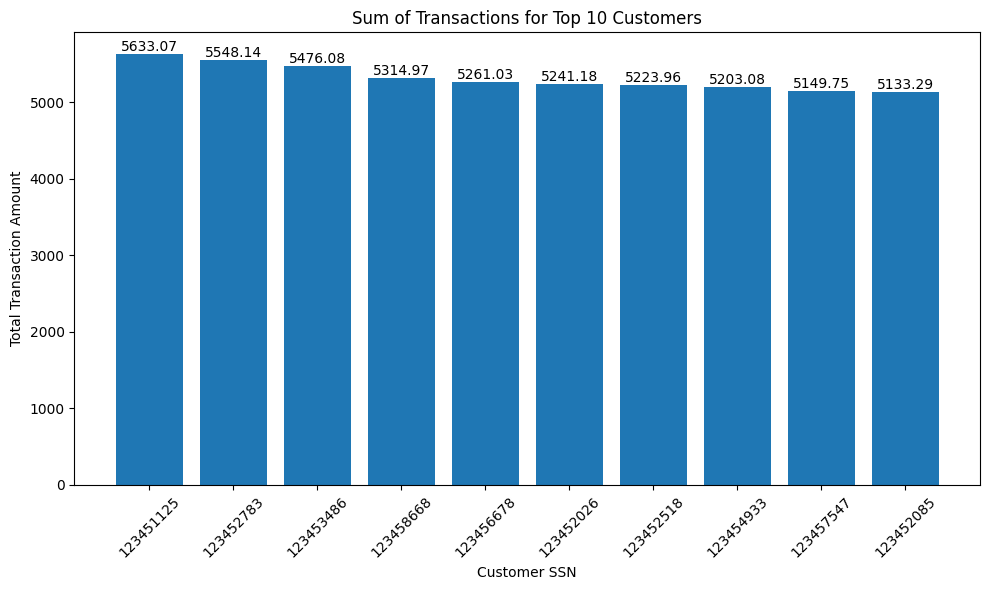

In [46]:
import matplotlib.pyplot as plt
import pandas as pd
import mysql.connector

# Establish a connection to the MySQL database
conn = mysql.connector.connect(user='root',
                               database='creditcard_capstone',
                               password='password',
                               host="localhost",
                               port=3306)

# Execute a query to get the sum of transactions for the top 10 customers
query = """
SELECT 
	CAST(CUST_SSN AS char) AS CUST_SSN,
	total_amount
FROM
(
SELECT CUST_SSN, ROUND(SUM(Transaction_Value),2) AS total_amount, RANK() OVER(ORDER BY SUM(Transaction_Value) DESC) as rankid
FROM creditcard
GROUP BY CUST_SSN
ORDER BY total_amount DESC
) nest
WHERE nest.rankid <= 10;
"""

# # Fetch the result into a Pandas DataFrame
df = pd.read_sql(query, conn)

# Plot the sum of transactions for the top 10 customers
plt.figure(figsize=(10, 6))
bars = plt.bar(df['CUST_SSN'], df['total_amount'])
plt.xlabel('Customer SSN')
plt.ylabel('Total Transaction Amount')
plt.title('Sum of Transactions for Top 10 Customers')
plt.xticks(rotation=45)
plt.tight_layout()

# Add the total count on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, height, ha='center', va='bottom')

# Save the plot as an image
plt.savefig('top_10_customers_transactions.png')

# # Get the customer with the highest transaction amount
customer_with_highest_amount = df.loc[df['total_amount'].idxmax()]

# # Print the customer with the highest transaction amount
print("Customer with the highest transaction amount:")
print(customer_with_highest_amount)

# Close the database connection
conn.close()


*********************************************************
* IV Functional Requirements - LOAN Application Dataset *
*********************************************************

4.1 Create a Python program to GET (consume) data from the above API endpoint for the loan application dataset.

In [47]:
from pyspark.sql import SparkSession, functions as F
from urllib.request import urlopen
import requests

spark = SparkSession.builder.getOrCreate()

url = 'https://raw.githubusercontent.com/platformps/LoanDataset/main/loan_data.json'

# Send GET request to the API endpoint
response = requests.get(url)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    # # Get the loan application data from the response
    # loan_data = response.json()

    # # Print the loan application data
    # print(loan_data)
    
    # Load the json data into a spark dataframe
    jsonData = urlopen(url).read().decode('utf-8')
    rdd = spark.sparkContext.parallelize([jsonData])
    df = spark.read.json(rdd)
    
    #BONUS: Instead of just showing the dataframe df, created a temp view for it.

    # Create a temporary view based on the spark dataframe 
    df.createOrReplaceGlobalTempView("loan_data")

    # Create a standard Dataframe by quering the temporary view
    loan_result_df = spark.sql("SELECT * FROM global_temp.loan_data")
    loan_result_df.show()

else:
    print("Error: Failed to retrieve loan application data from the API.")


+--------------+------------------+--------------+----------+------------+------+------+-------+-------------+-------------+
|Application_ID|Application_Status|Credit_History|Dependents|   Education|Gender|Income|Married|Property_Area|Self_Employed|
+--------------+------------------+--------------+----------+------------+------+------+-------+-------------+-------------+
|      LP001002|                 Y|             1|         0|    Graduate|  Male|medium|     No|        Urban|           No|
|      LP001003|                 N|             1|         1|    Graduate|  Male|medium|    Yes|        Rural|           No|
|      LP001005|                 Y|             1|         0|    Graduate|  Male|   low|    Yes|        Urban|          Yes|
|      LP001006|                 Y|             1|         0|Not Graduate|  Male|   low|    Yes|        Urban|           No|
|      LP001008|                 Y|             1|         0|    Graduate|  Male|medium|     No|        Urban|           No|


4.2
Find the status code of the above API endpoint.
Hint: status code could be 200, 400, 404, 401.

In [49]:
from pyspark.sql import SparkSession, functions as F
from urllib.request import urlopen
import requests

# API endpoint URL
url = "https://raw.githubusercontent.com/platformps/LoanDataset/main/loan_data.json"

# Send GET request to the API endpoint
response = requests.get(url)

# Print the status code of the response
print("Status Code:", response.status_code)

Status Code: 200


4.3
Once Python reads data from the API, utilize PySpark to load data into RDBMS (SQL).
The table name should be CDW-SAPP_loan_application in the database.
Note: Use the “creditcard_capstone” database.

In [50]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Loan Application Data").getOrCreate()

# Load loan application data from API into PySpark DataFrame
url = "https://raw.githubusercontent.com/platformps/LoanDataset/main/loan_data.json"
# loan_data = spark.read.json(url)

# Send GET request to the API endpoint
response = requests.get(url)

# Check if the request was successful (status code 200)
if response.status_code == 200:

    # Read Data, Create and RDD and load into Spark Dataframe
    jsonData = urlopen(url).read().decode('utf-8')
    rdd = spark.sparkContext.parallelize([jsonData])
    loan_data = spark.read.json(rdd)

# Write loan application data to the RDBMS table
    loan_data.write \
        .format("jdbc") \
        .option("driver","com.mysql.cj.jdbc.Driver") \
        .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
        .option("dbtable", "CDW_SAPP_loan_application") \
        .option("user", "root") \
        .option("password", "password") \
        .mode("overwrite") \
        .save()

# Stop the SparkSession
spark.stop()


V. Functional Requirements - Data Analysis and Visualization for LOAN Application

5.1
Find and plot the percentage of applications approved for self-employed applicants.
Note: Take a screenshot of the graph. 

C:\Users\ibadw\AppData\Local\Temp\ipykernel_25468\1840950364.py:22: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


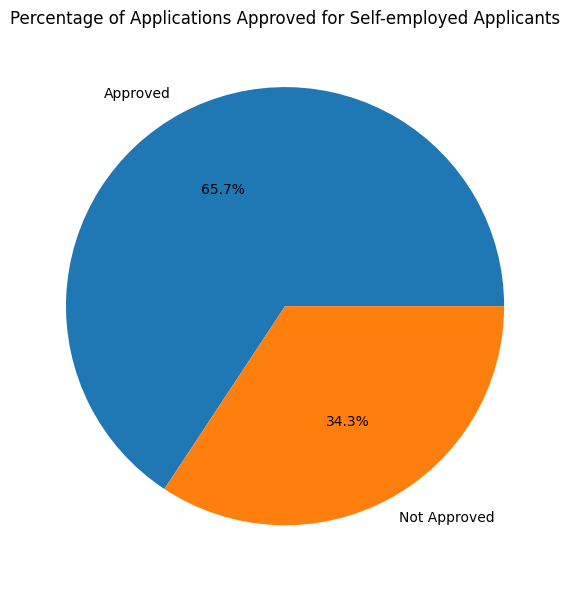

In [51]:
import matplotlib.pyplot as plt
import pandas as pd
import mysql.connector

# Establish a connection to the MySQL database
conn = mysql.connector.connect(user='root', 
                               database='creditcard_capstone',
                               password='password',
                               host="localhost",
                               port=3306)
cursor = conn.cursor()

# Execute a query to get the count of approved and self-employed applications
query = """
SELECT COUNT(*) AS total_count,
       SUM(CASE WHEN Application_Status = 'Y' THEN 1 ELSE 0 END) AS self_employed_count
FROM CDW_SAPP_loan_application
WHERE Self_Employed = 'Yes'
"""

# Fetch the result into a Pandas DataFrame
df = pd.read_sql(query, conn)

# Calculate the percentage of applications approved for self-employed applicants
self_employed_percentage = (df['self_employed_count'] / df['total_count']) * 100

# Plot the percentage of applications approved for self-employed applicants
plt.figure(figsize=(6, 6))
plt.pie([self_employed_percentage[0], 100 - self_employed_percentage[0]],
        labels=['Approved', 'Not Approved'],
        autopct='%1.1f%%')
plt.title('Percentage of Applications Approved for Self-employed Applicants')
plt.tight_layout()

# Save the plot as an image
plt.savefig('self_employed_approval_percentage.png')

# Close the database connection
conn.close()


5.2
Find the percentage of rejection for married male applicants.
Note: Take a screenshot of the graph.

C:\Users\ibadw\AppData\Local\Temp\ipykernel_25468\176152048.py:22: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


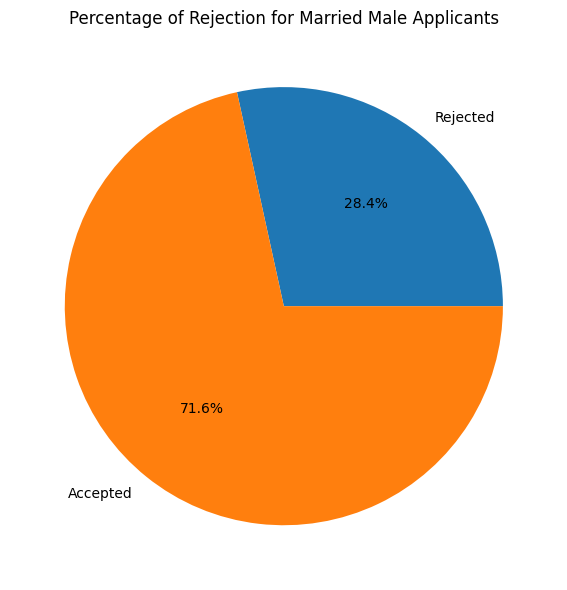

In [52]:
import matplotlib.pyplot as plt
import pandas as pd
import mysql.connector

# Establish a connection to the MySQL database
conn = mysql.connector.connect(user='root', 
                               database='creditcard_capstone',
                               password='password',
                               host="localhost",
                               port=3306)
cursor = conn.cursor()

# Execute a query to get the count of rejected and married male applications
query = """
SELECT COUNT(*) AS total_count,
       SUM(CASE WHEN Application_Status = 'N' THEN 1 ELSE 0 END) AS married_male_count
FROM CDW_SAPP_loan_application
WHERE Gender = 'Male' AND Married = 'Yes'
"""

# Fetch the result into a Pandas DataFrame
df = pd.read_sql(query, conn)

# Calculate the percentage of rejection for married male applicants
married_male_percentage = (df.iloc[0]['married_male_count'] / df.iloc[0]['total_count']) * 100

# Plot the percentage of rejection for married male applicants
plt.figure(figsize=(6, 6))
plt.pie([married_male_percentage, 100 - married_male_percentage],
        labels=['Rejected', 'Accepted'],
        autopct='%1.1f%%')
plt.title('Percentage of Rejection for Married Male Applicants')
plt.tight_layout()

# Save the plot as an image
plt.savefig('married_male_rejection_percentage.png')

# Close the database connection
conn.close()


5.3
Find and plot the top three months with the largest transaction data.
Note: Take a screenshot of the graph.

C:\Users\ibadw\AppData\Local\Temp\ipykernel_25468\2544372973.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


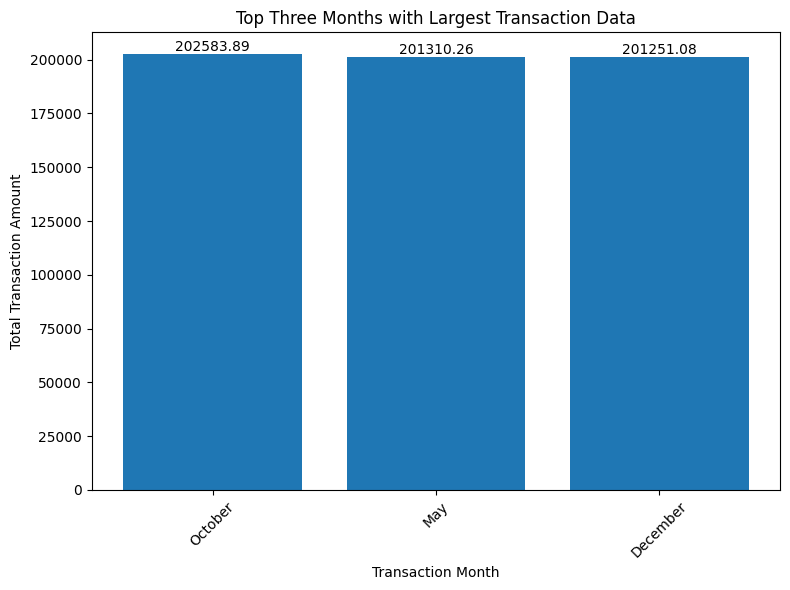

In [53]:
import matplotlib.pyplot as plt
import pandas as pd
import mysql.connector
import calendar

# Establish a connection to the MySQL database
conn = mysql.connector.connect(user='root', 
                               database='creditcard_capstone',
                               password='password',
                               host="localhost",
                               port=3306)
cursor = conn.cursor()

# Execute a query to get the sum of transaction data by month
query = """
SELECT month, ROUND(SUM(Transaction_Value),2) AS total_amount
FROM creditcard
GROUP BY month
ORDER BY total_amount DESC
LIMIT 3
"""
# Fetch the result into a Pandas DataFrame
df = pd.read_sql(query, conn)

# Add a new column to the existing DataFrame
df['monthName'] = df['month'].apply(lambda x: calendar.month_name[x])

df.head()

# Plot the top three months with the largest transaction data
plt.figure(figsize=(8, 6))
bars = plt.bar(df['monthName'], df['total_amount'])
plt.xlabel('Transaction Month')
plt.ylabel('Total Transaction Amount')
plt.title('Top Three Months with Largest Transaction Data')
plt.xticks(rotation=45)
plt.tight_layout()

# Add the total count on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, height, ha='center', va='bottom')

# Save the plot as an image
plt.savefig('top_three_months_transaction.png')

# Close the database connection
conn.close()


5.4
Find and plot which branch processed the highest total dollar value of healthcare transactions.
Note: Take a screenshot of the graph. 

C:\Users\ibadw\AppData\Local\Temp\ipykernel_25468\1626592151.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


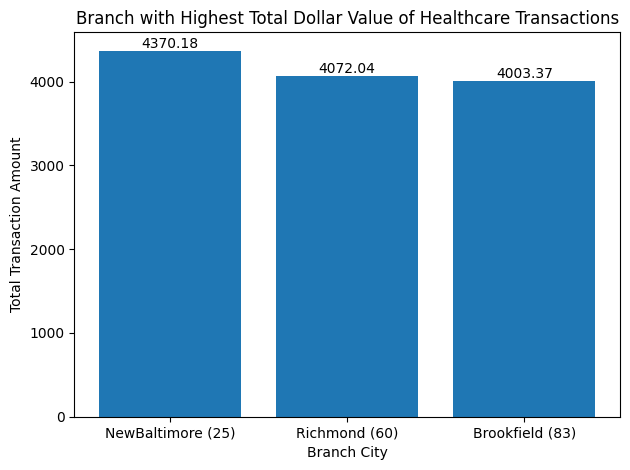

In [54]:
import matplotlib.pyplot as plt
import pandas as pd
import mysql.connector

# Establish a connection to the MySQL database
conn = mysql.connector.connect(user='root', 
                               database='creditcard_capstone',
                               password='password',
                               host="localhost",
                               port=3306)
cursor = conn.cursor()

# Execute a query to get the total dollar value of healthcare transactions by branch
query = """
SELECT CONCAT (branch.Branch_City, ' (', cc.Branch_Code, ')') AS BranchCity, ROUND(SUM(cc.Transaction_Value),2) AS total_amount
FROM creditcard AS cc
JOIN branch on cc.Branch_Code = branch.Branch_Code
WHERE Transaction_Type = 'Healthcare'
GROUP BY BranchCity
ORDER BY total_amount DESC
LIMIT 3
"""

# Fetch the result into a Pandas DataFrame
df = pd.read_sql(query, conn)

# Plot the branch with the highest total dollar value of healthcare transactions
# plt.figure(figsize=(6, 6))
bars =plt.bar(df['BranchCity'], df['total_amount'])
plt.xlabel('Branch City')
plt.ylabel('Total Transaction Amount')
plt.title('Branch with Highest Total Dollar Value of Healthcare Transactions')
plt.tight_layout()

# Add the total count on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, height, ha='center', va='bottom')

# Save the plot as an image
plt.savefig('highest_healthcare_transactions.png')

# Close the database connection
conn.close()
